# Optimization final project

Kenwan Cheung, Joan Lee, Chantel Miller, Anthony Smaniotto.

### Background: 
As computing power and data size have grown exponentially in the past decade there has been a massive improvement in the accuracy and complexity of neural networks. While theorized by Minksy and others in the 60s, it was the breakthrough in the early 1980s by Geoffrey Hinton and his co-authors with the development of “back-propogation” that enabled development of deeper networks. When combined with the improvements in raw computing power and scale of data, we’ve seen neural networks become proficient at a variety of tasks, from image recognition to beating the best human players in the game of Go.

### Problem: 

As neural networks have gotten deeper and more complex, parameter estimation and the relevant optimization methodology is now a critical step to building neural networks.

At a simple level, neural networks could be thought of as a host of regressions set up in m-layers. We must figure out the weights of each one of those connections. In the simple example below with just one set of hidden layers, The number of parameters to be estimated is calculated by the sum of the product of the numbers of nodes in connected layers. Parameters: (3×4)+(4×2)=20. 

We can intuitively see how quickly the parameter estimation process grows. Many of the advances in the past decade have come hand in hand with advances in the optimization methods used to optimize the parameter estimation and improve time to convergence. 

### Our goal: 

Our team will seek to hand-code neural networks while implementing several of the most common optimization methods such as: stochastic gradient descent, Adagrad, ADAM. We will seek to gain a deeper understanding over how they converge by leveraging the age old Francisco™ method: simulation, development of our own functions, and visualization. We will complete this in Python.


In [2]:
# IMPORT PACKAGES

# Import relevant packages

%matplotlib inline
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from imutils import paths
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D, ZeroPadding2D
from keras.optimizers import RMSprop, adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils,to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.metrics import binary_accuracy,binary_crossentropy
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l2 # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation
from sklearn import svm
import random 
import argparse
import datetime
import imutils
import cv2
import os
import re
import shutil
from IPython.display import Image
K.set_image_dim_ordering('th')


C:\Users\Joan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Part 1

Simulation of the dataset.

Let's begin by simulating a simple data generation process.

Let's simulate a multivariate normal distribution. We might use a logistic regression in this scenario.

In [3]:
# set seed
np.random.seed(12)
n = 10000

x_1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], n)
x_2 = np.random.multivariate_normal([1, 4], [[2, .75],[.75, 2]], n)
x_3 = np.random.multivariate_normal([2, 8], [[3, .75],[.75, 3]], n)

simulated_separableish_features = np.vstack((x_1, x_2, x_3)).astype(np.float32)
y = np.hstack((np.zeros(n),
               np.ones(n),
              np.ones(n)+1))


In [4]:
print(x_1.shape,x_2.shape,x_3.shape)
print(y.shape)

(10000, 2) (10000, 2) (10000, 2)
(30000,)


Text(0.5,1,'simulated data multivariate')

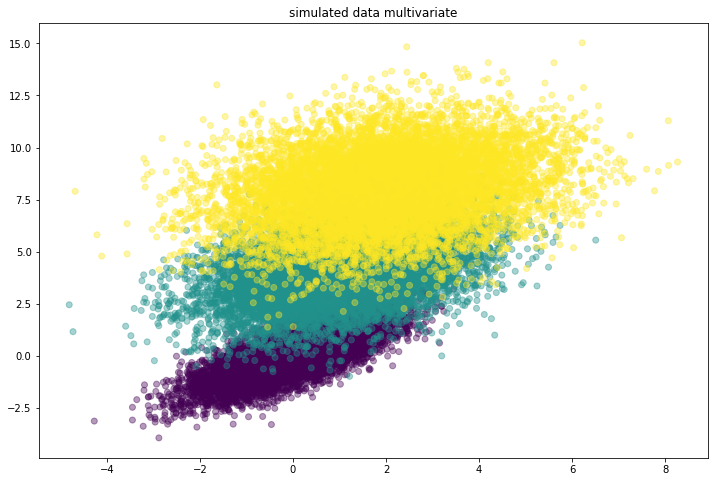

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = y, alpha = .4)
plt.title("simulated data multivariate")

# Part 2

Let's begin by setting up a function for a small NN.

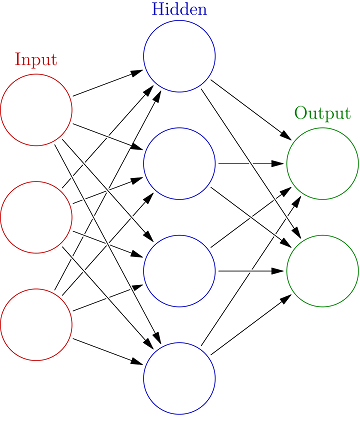

In [6]:
Image("../optimization_final/raw/neural_network_hidden.png")

### Discussion of how to build a neural net.

Neural  nets at their core are typically built around sigmoid functions. The biggest discrepancy with a more traditional approach would be the rise of "hidden" layers whose weights we are trying to calculate.

    1) Input layer weights - just like we would for a logistic regression. 
    2) We develop a hidden layer around some "activation function". Originally these were sigmoid functions, but advancements have been made to move away from the sigmoid (how our own neurons work), to something like the ReLu.
    3) Go from hidden layer to outputs layer.
    4) Translate output layer to output values with a probability distribution. Typically softmax. 

In a traditional logistic regression, the optimization occurs around the log-likelihood, which we try and maximize given a series of coefficients.

#### Log-Likelihood optimization
$ll =  \sum_{i=1}^N y_i\beta^Tx_i - log(1+e^{\beta^Tx_i})$


#### Neural network optimization
We can think about neural nets as something similar. We must optimize the errors around a particular set of weights for each layer. We do this iteratively until we reach some threshold of tolerance.



# Building our networks

In order for us to build our network, we'll need several things:

    1) initialize arrays with the correct size.
    2) set up an activation fx
    3) set up a output function
    4) set up a loss function
    5) set up back propogation / gradient passing to allow the network to adjust the next iteration. In a sense we're calculating the error as each coefficient changes. Or the derivative of the error with respect to a given weight.
    
### Setting up the shape of our arrays

We need to ensure our matrices line up! We need to do the following matrix multiplications:

    1) We start with random weights * input of shape (n * features)
    2) So our weights array must have shape of (features * hidden nodes)
    3) Bias term has shape of (1, number of hidden nodes)

Next layer for hidden. 
    
    4) weights now must be of shape (hidden nodes * num_labels)
    5) bias term is now (1, # of labels)

In [7]:
hidden_nodes = 5
num_features = 2
num_labels = 3

In [8]:
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer1_biases_array = np.zeros((1, hidden_nodes))

layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 
layer2_biases_array = np.zeros((1, num_labels))


### Activation fx

Original nets modeled their construction on a sigmoid after finding that is how our own physiology was designed. However, mnewer work has come on modified sigmoid fx that help to speed up convergence.

In this case ReLu (rectified linear unit) has a value of 0 and then a linear increase past 0, which helps dead neurons to stay dead, and speed up how quickly we find optimal weights

$f(x)=x^{+}=\max(0,x)$

In [9]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

### Softmax - from output layer to output itself.

The softmax allows us to transform a given output layer to an actual distribution, and corresponding output classification.

$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}} for j = 1, …, K $

In [10]:
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims=True)

### Loss function

We need some way to evaluate each series of estimates. We will use cross entropy given we're looking at a classification issue and want some binary decision rather than that of a squared distance metric.

$H(p,q)=-\sum _{x}p(x)\,\log q(x)$

In [11]:
def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

### Regularization 

While not necessary, this step also helps to prevent overfitting. We'll also implement some additional overfit steps in the later steps.

In [12]:
def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss


### Back propagation

For EACH layer, we are looking to see the error gradient with respect to the previous. 

So, the error gradient for layer2_weights_array would be the hidden_layer values times the error signal of the softmaxed output_layer.

Hinton et al. established that the error signal at the end of a given layer is the matrix multiplication of the error signal from the next layer in the network (say the output layer in layer2_weights_array) and the transpose of the weights coming out of the current layer (hidden layer). 

This is then multiplied by the derivative of the layer’s activation function (relu).

In [13]:
# # Allows us to calculate the loss at a given layer
# output_error_signal = (output_probs - labels_onehot) / output_probs.shape[0]

# # derivative of activation function from above.
# error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
# error_signal_hidden[hidden_layer <= 0] = 0

# # updated gradient
# gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
# gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

# # now flow through to layer 1
# gradient_layer1_weights = np.dot(data.T, error_signal_hidden)
# gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

# # regularization.
# reg_lambda = .01
# learning_rate = .01

# gradient_layer2_weights += reg_lambda * layer2_weights_array
# gradient_layer1_weights += reg_lambda * layer1_weights_array

# layer1_weights_array -= learning_rate * gradient_layer1_weights
# layer1_biases_array -= learning_rate * gradient_layer1_bias
# layer2_weights_array -= learning_rate * gradient_layer2_weights
# layer2_biases_array -= learning_rate * gradient_layer2_bias


In [14]:
# accuracy
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

# Now coding up the exact algorithm

First let's segment our data into train and test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, y, test_size=0.2, random_state=42)

In [16]:
y_train

array([2., 0., 2., ..., 0., 1., 2.])

In [17]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

## Batch Gradient Descent

Training on the full data set at once.

Using different learning rates on our training data.

In [29]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1, 1, 10]
reg_lambda = .01

bgd_losses_train=[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
   
    for step in range(0,n+1):

        input_layer = np.dot(X_train, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

        output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias

        bgd_losses_train.append(loss)
        
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))



Training with learning rate:1e-05
Loss at step 0: 2.9277843291444325
Loss at step 500: 2.8799207147506882
Loss at step 1000: 2.833416292932574
Loss at step 1500: 2.7880808865501976
Loss at step 2000: 2.7437726863871603
Loss at step 2500: 2.7003837746747603
Loss at step 3000: 2.6578304819132055
Loss at step 3500: 2.6160481510634463
Loss at step 4000: 2.5749838741157687
Loss at step 4500: 2.534595472553933
Loss at step 5000: 2.494848123506986
Loss at step 5500: 2.4557139465433533
Loss at step 6000: 2.4171686655291045
Loss at step 6500: 2.3791919486402477
Loss at step 7000: 2.341766342050531
Loss at step 7500: 2.304876465699603
Loss at step 8000: 2.2685089438780004
Loss at step 8500: 2.232653075388861
Loss at step 9000: 2.1972989173996194
Loss at step 9500: 2.1624387428705614
Loss at step 10000: 2.1280654480620975

Training with learning rate:0.0001
Loss at step 0: 2.1279971849707886
Loss at step 500: 1.8101920807643366
Loss at step 1000: 1.540971583047267
Loss at step 1500: 1.3313283698

C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in maximum
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal


Loss at step 500: nan
Loss at step 1000: nan
Loss at step 1500: nan
Loss at step 2000: nan
Loss at step 2500: nan
Loss at step 3000: nan
Loss at step 3500: nan
Loss at step 4000: nan
Loss at step 4500: nan
Loss at step 5000: nan
Loss at step 5500: nan
Loss at step 6000: nan
Loss at step 6500: nan
Loss at step 7000: nan
Loss at step 7500: nan
Loss at step 8000: nan
Loss at step 8500: nan
Loss at step 9000: nan
Loss at step 9500: nan
Loss at step 10000: nan


In [46]:
bgd_losses_train[20001]

0.9065591382058283

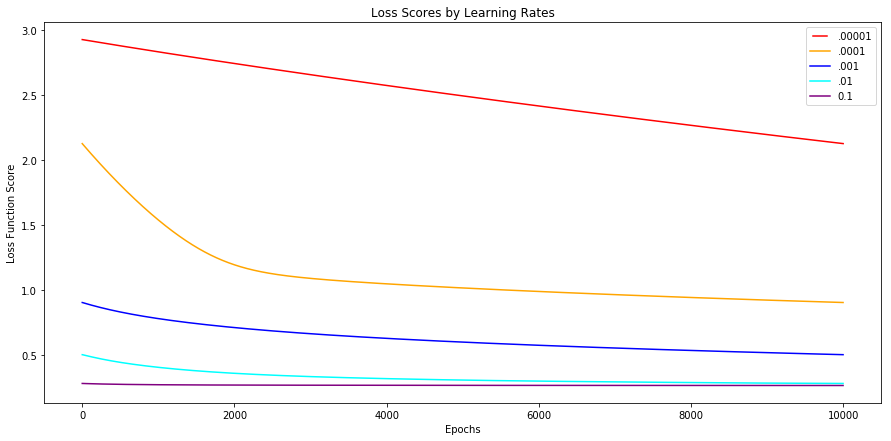

In [98]:
#plt.plot(bgd_losses_train[0:10000], color='red', label='.1')

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses_train[0:10000], color='red', label='.00001')
line2, = plt.plot(bgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(bgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(bgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(bgd_losses_train[40001:50000], color='purple',label='0.1')
#line6, = plt.plot(bgd_losses_train[50001:60000], color='pink',label='1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores by Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


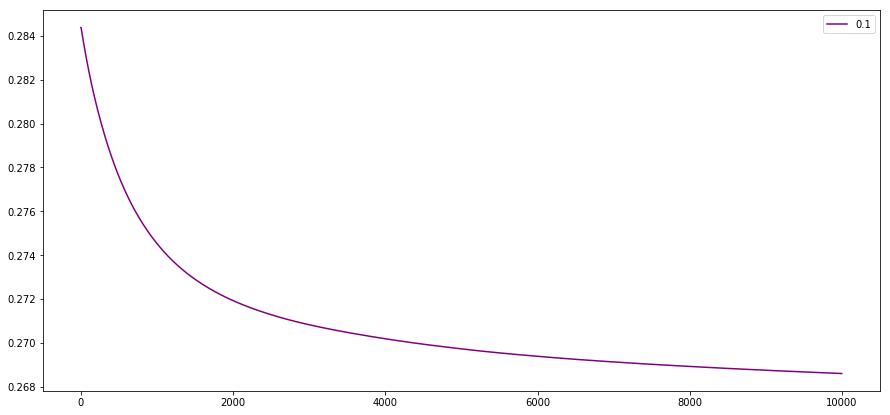

In [77]:
plt.figure(figsize=(15,7))

line5, = plt.plot(bgd_losses_train[40001:50000], color='purple',label='0.1')
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Score for Batch Gradient Descent w/ Learning Rate=0.01')


plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


From the above, we see that a learning rate of .1 convereged to the lowest loss score of all of the different learning rates. Now we will remove the regularizer, but run the same learning rates on the training data.

In [56]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1, 1, 10]
#reg_lambda = .01
bgd_losses_train_noreg=[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
   
    for step in range(0,n+1):

        input_layer = np.dot(X_train, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

        output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        #gradient_layer2_weights += reg_lambda * layer2_weights_array
        #gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias

        bgd_losses_train_noreg.append(loss)
        
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))



Training with learning rate:1e-05
Loss at step 0: 3.0795645837006647
Loss at step 500: 3.005857137412311
Loss at step 1000: 2.9367075796315816
Loss at step 1500: 2.8717410348595167
Loss at step 2000: 2.8106863605096537
Loss at step 2500: 2.7532574940144605
Loss at step 3000: 2.6992000547341686
Loss at step 3500: 2.6482408264986117
Loss at step 4000: 2.60015152680113
Loss at step 4500: 2.5547046060014
Loss at step 5000: 2.511700328679273
Loss at step 5500: 2.4709389292028887
Loss at step 6000: 2.4322587595097955
Loss at step 6500: 2.3955214551939843
Loss at step 7000: 2.360603135447897
Loss at step 7500: 2.327372112136186
Loss at step 8000: 2.2957353124927664
Loss at step 8500: 2.2656174824050703
Loss at step 9000: 2.2369135360566323
Loss at step 9500: 2.2095532620660747
Loss at step 10000: 2.183469131866739

Training with learning rate:0.0001
Loss at step 0: 2.1834182164194877
Loss at step 500: 1.97983750087778
Loss at step 1000: 1.8477192945737368
Loss at step 1500: 1.754917741655635

C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in maximum
  
C:\Users\Joan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal


Loss at step 500: nan
Loss at step 1000: nan
Loss at step 1500: nan
Loss at step 2000: nan
Loss at step 2500: nan
Loss at step 3000: nan
Loss at step 3500: nan
Loss at step 4000: nan
Loss at step 4500: nan
Loss at step 5000: nan
Loss at step 5500: nan
Loss at step 6000: nan
Loss at step 6500: nan
Loss at step 7000: nan
Loss at step 7500: nan
Loss at step 8000: nan
Loss at step 8500: nan
Loss at step 9000: nan
Loss at step 9500: nan
Loss at step 10000: nan


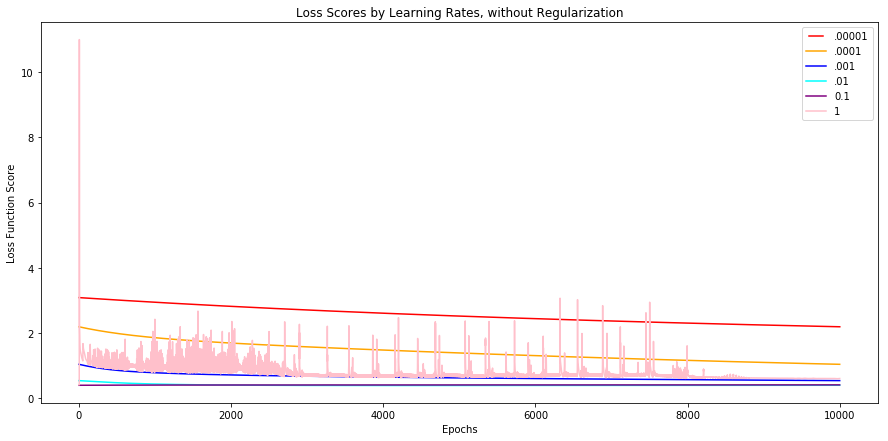

In [76]:
plt.figure(figsize=(15,7))
line1, = plt.plot(bgd_losses_train_noreg[0:10000], color='red', label='.00001')
line2, = plt.plot(bgd_losses_train_noreg[10001:20000], color='orange', label='.0001')
line3, = plt.plot(bgd_losses_train_noreg[20001:30000], color='blue',label='.001')
line4, = plt.plot(bgd_losses_train_noreg[30001:40000], color='cyan',label='.01')
line5, = plt.plot(bgd_losses_train_noreg[40001:50000], color='purple',label='0.1')
#line6, = plt.plot(bgd_losses_train_noreg[50001:60000], color='pink',label='1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores by Learning Rates, without Regularization')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

Below, we will use a learning rate of 0.1, which yielded the lowest loss score from our exploration above; we will also use the regularization lambda value of .01, becuase also from the above, we saw that removing the regularizer did not yield lower loss scores than when we did use it.

In [85]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .1
#learning_rate = .01
reg_lambda = .01

bgd_losses =[]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):

    input_layer = np.dot(X_train, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    bgd_losses.append(loss)
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))


Loss at step 0: 2.597404907119939
Loss at step 500: 0.319302472083167
Loss at step 1000: 0.28782248492181367
Loss at step 1500: 0.2807885366787253
Loss at step 2000: 0.2769541143911246
Loss at step 2500: 0.2747857616023409
Loss at step 3000: 0.273318202966768
Loss at step 3500: 0.27225697215106237
Loss at step 4000: 0.2714732854172388
Loss at step 4500: 0.2708618708654143
Loss at step 5000: 0.2703663368971549
Loss at step 5500: 0.2699618576479229
Loss at step 6000: 0.2696160116355575
Loss at step 6500: 0.2693206839038755
Loss at step 7000: 0.26906593037288884
Loss at step 7500: 0.2688516472444903
Loss at step 8000: 0.2686714887756547
Loss at step 8500: 0.26851817220526925
Loss at step 9000: 0.2683831760556877
Loss at step 9500: 0.26825960601820087
Loss at step 10000: 0.2681509548905604


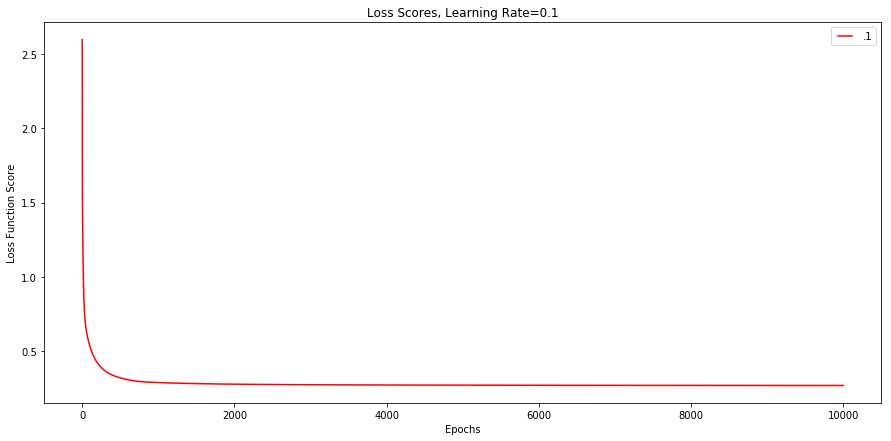

In [86]:
plt.figure(figsize=(15,7))
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores, Learning Rate=0.1')
line1, = plt.plot(bgd_losses, color='red', label='.1')
#line2, = plt.plot([1,2,3], marker='o', label='Line 2')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

#plt.plot(year, pop_pakistan, color='g')
#plt.plot(year, pop_india, color='orange')

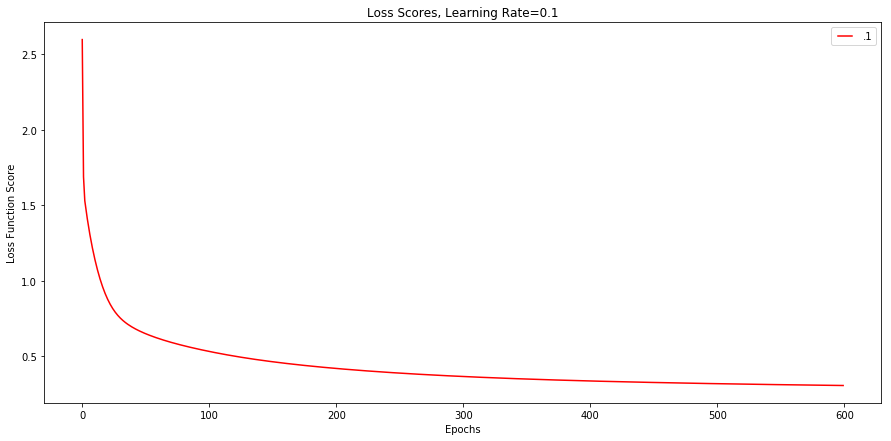

In [87]:
plt.figure(figsize=(15,7))
plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Loss Scores, Learning Rate=0.1')
line1, = plt.plot(bgd_losses[0:600], color='red', label='.1')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


### Shape of some outputs

In [88]:
output_probs

array([[2.95209523e-10, 1.94924317e-03, 9.98050757e-01],
       [9.92119476e-01, 7.87216674e-03, 8.35698448e-06],
       [6.79226322e-06, 1.93527218e-01, 8.06465990e-01],
       ...,
       [9.75968669e-01, 2.39880264e-02, 4.33050076e-05],
       [2.54063924e-03, 9.43972867e-01, 5.34864941e-02],
       [4.52440248e-05, 4.27883990e-01, 5.72070766e-01]])

In [89]:
loss

0.2681509548905604

In [90]:
output_error_signal

array([[ 1.23003968e-14,  8.12184655e-08, -8.12184778e-08],
       [-3.28355155e-07,  3.28006948e-07,  3.48207687e-10],
       [ 2.83010967e-10,  8.06363408e-06, -8.06391709e-06],
       ...,
       [-1.00130548e-06,  9.99501101e-07,  1.80437532e-09],
       [ 1.05859968e-07, -2.33446389e-06,  2.22860392e-06],
       [ 1.88516770e-09,  1.78284996e-05, -1.78303847e-05]])

In [91]:
error_signal_hidden

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.00847205e-08],
       [ 0.00000000e+00, -1.07383129e-07, -4.48827257e-07,
        -4.60284017e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.28440221e-06, -6.95880844e-06],
       ...,
       [ 0.00000000e+00, -3.27335293e-07, -1.36815578e-06,
        -1.46148421e-08,  1.15889999e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.73540652e-06,  1.80074094e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.38956591e-05, -1.53882993e-05]])

In [92]:
gradient_layer1_weights

array([[-1.00687047e-07, -8.66982090e-06, -5.52434672e-05,
        -2.59847057e-05, -4.68445348e-05],
       [-1.94557784e-07,  2.51064239e-05,  9.06964099e-05,
         8.05055184e-05,  2.77800349e-05]])

In [93]:
layer1_weights_array

array([[-1.00586360e-05,  9.03330950e-02,  3.86847105e-01,
        -5.50930051e-02, -1.95801661e-01],
       [-1.94363226e-05, -1.93623610e-01, -8.00805340e-01,
        -3.74397538e-01,  1.42060291e+00]])

# Predictions

In [94]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 90.98333333333333%


### Plot of predictions

Let's compare results.

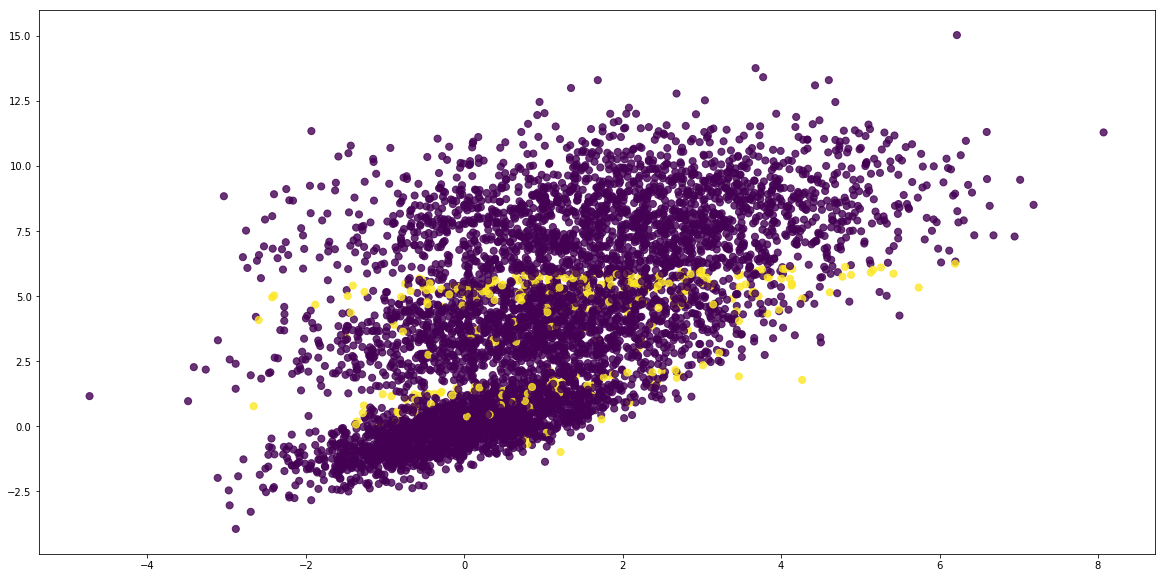

In [95]:
labels_flat = np.argmax(y_test_enc, axis = 1)
predictions = np.argmax(probs, axis = 1)
plt.figure(figsize = (20, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)

## Minibatch Gradient Descent

Training on the dataset in batches and updating the weights after each batch.

In [114]:
from sklearn.utils import shuffle

hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, .1]
#learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

mbgd_losses_train = []

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for learning_rate in learning_rates:
    print ("\nTraining with learning rate:" + str(learning_rate))
    
    for step in range(0,n+1):

        X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)

        step_loss = []

        #learning_rate *= 1/(1+0.01*1)

        # Get pair of (X, y) of the current minibatch/chunk
        for i in range(0, X_train.shape[0], minibatch_size):
            X_train_mini = X_train_rand[i:i + minibatch_size]
            y_train_mini = y_train_rand[i:i + minibatch_size]

            input_layer = np.dot(X_train_mini, layer1_weights_array)
            hidden_layer = relu_activation(input_layer + layer1_biases_array)
            output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
            output_probs = softmax(output_layer)

            loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
            loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
            step_loss.append(loss)

            output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

            error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
            error_signal_hidden[hidden_layer <= 0] = 0

            gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
            gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

            gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
            gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

            gradient_layer2_weights += reg_lambda * layer2_weights_array
            gradient_layer1_weights += reg_lambda * layer1_weights_array

            layer1_weights_array -= learning_rate * gradient_layer1_weights
            layer1_biases_array -= learning_rate * gradient_layer1_bias
            layer2_weights_array -= learning_rate * gradient_layer2_weights
            layer2_biases_array -= learning_rate * gradient_layer2_bias

        mbgd_losses_train.append(np.average(step_loss))
        if step % 500 == 0:
                print('Loss at step {0}: {1}'.format(step, loss))
                #print learning_rate
        



Training with learning rate:1e-05
Loss at step 0: 11.453009476180249
Loss at step 500: 1.1387929198500533
Loss at step 1000: 0.9388082294446298
Loss at step 1500: 0.8402972823129855
Loss at step 2000: 0.7875513487921946
Loss at step 2500: 0.7689266214775833
Loss at step 3000: 0.7145216522589226
Loss at step 3500: 0.7078768977846752
Loss at step 4000: 0.670011757075923
Loss at step 4500: 0.6526292539696164
Loss at step 5000: 0.6457470619943385
Loss at step 5500: 0.6350378770292521
Loss at step 6000: 0.6214324820732045
Loss at step 6500: 0.5937785762568272
Loss at step 7000: 0.5595436530246953
Loss at step 7500: 0.5796649472567913
Loss at step 8000: 0.5394923696810008
Loss at step 8500: 0.5376282707873741
Loss at step 9000: 0.5270523754600183
Loss at step 9500: 0.5218145056288357
Loss at step 10000: 0.47135633920823494

Training with learning rate:0.0001
Loss at step 0: 0.5231899692417764
Loss at step 500: 0.45701916560956096
Loss at step 1000: 0.4274007718398707
Loss at step 1500: 0.41

In [96]:
mbgd_losses_train

[1.2747495987890978,
 1.2739971678387398,
 1.2734854651190466,
 1.272976210951703,
 1.272525104238271,
 1.2719579602757418,
 1.2712576200749248,
 1.2706872280499342,
 1.2704250334016496,
 1.2694177244831266,
 1.2692771590654046,
 1.2684025873257274,
 1.2681364267702906,
 1.2674430101523908,
 1.266704347652289,
 1.2660844938131284,
 1.265630756054621,
 1.2648732817425556,
 1.264667565015124,
 1.2639825292824898,
 1.2631123018195196,
 1.2628555262669612,
 1.2619534689120635,
 1.2617763481321846,
 1.2610019628315996,
 1.260319584923457,
 1.2602028226525244,
 1.259363926205684,
 1.2585935946970601,
 1.258132666738425,
 1.2573631128658938,
 1.256916779853387,
 1.2564242580092508,
 1.2560070805511194,
 1.2553595919698075,
 1.2545618535606453,
 1.254198615526908,
 1.2534380087474348,
 1.253281929488419,
 1.2521565369587149,
 1.2521259659897601,
 1.2513788175955114,
 1.250879126223815,
 1.2499785307546871,
 1.2497692724577247,
 1.2492322027961267,
 1.248357436265211,
 1.248359523491885,
 1.247

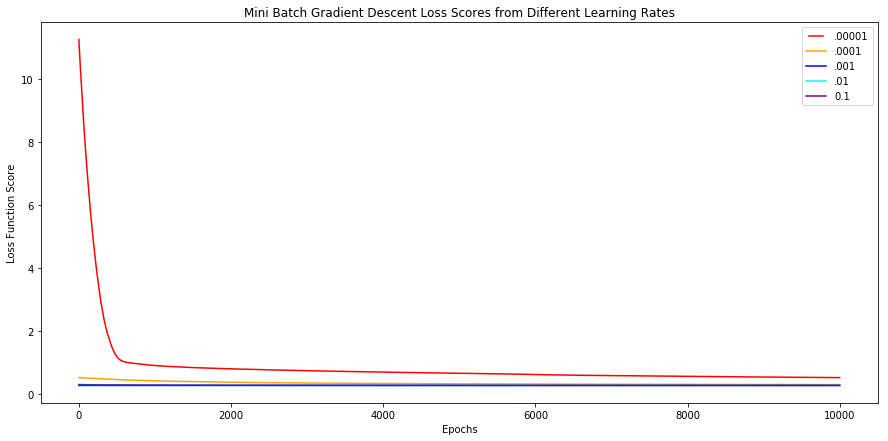

In [115]:
plt.figure(figsize=(15,7))
line1, = plt.plot(mbgd_losses_train[0:10000], color='red', label='.00001')
line2, = plt.plot(mbgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(mbgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(mbgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(mbgd_losses_train[40001:50000], color='purple',label='0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('Mini Batch Gradient Descent Loss Scores from Different Learning Rates')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


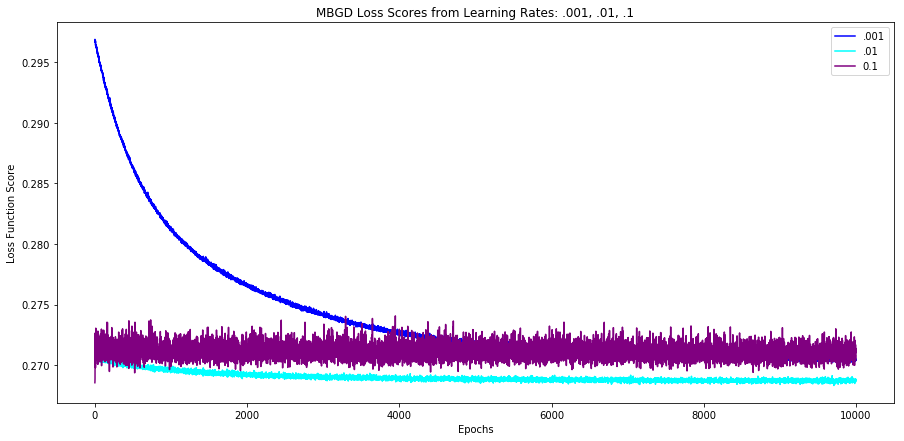

In [120]:
#plotting the loss scores for the three learning rates with lowest loss scores
plt.figure(figsize=(15,7))
#line1, = plt.plot(mbgd_losses_train[0:10000], color='red', label='.00001')
#line2, = plt.plot(mbgd_losses_train[10001:20000], color='orange', label='.0001')
line3, = plt.plot(mbgd_losses_train[20001:30000], color='blue',label='.001')
line4, = plt.plot(mbgd_losses_train[30001:40000], color='cyan',label='.01')
line5, = plt.plot(mbgd_losses_train[40001:50000], color='purple',label='0.1')

plt.xlabel('Epochs')
plt.ylabel('Loss Function Score')
plt.title('MBGD Loss Scores from Learning Rates: .001, .01, .1')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

As we can see from the graph above, a learning rate of .01 has a lower loss score than 1e-1 or 1e-3, so we will train our algorithm with that learning rate.

In [121]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

mbgd_losses = []

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):
    
    X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)
    
    step_loss = []
    
    #learning_rate *= 1/(1+0.01*1)
    
    # Get pair of (X, y) of the current minibatch/chunk
    for i in range(0, X_train.shape[0], minibatch_size):
        X_train_mini = X_train_rand[i:i + minibatch_size]
        y_train_mini = y_train_rand[i:i + minibatch_size]

        input_layer = np.dot(X_train_mini, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
        step_loss.append(loss)

        output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias
        
    mbgd_losses.append(np.average(step_loss))

    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            #print learning_rate


Loss at step 0: 0.9303802709180898
Loss at step 500: 0.24820164104414605
Loss at step 1000: 0.24360335397924937
Loss at step 1500: 0.23456404877031922
Loss at step 2000: 0.2645894419739528
Loss at step 2500: 0.2683641682931434
Loss at step 3000: 0.2587237659566102
Loss at step 3500: 0.3009222005100605
Loss at step 4000: 0.2720738189480498
Loss at step 4500: 0.23904255487022363
Loss at step 5000: 0.22947437930389883
Loss at step 5500: 0.27877884214206633
Loss at step 6000: 0.2204632830235434
Loss at step 6500: 0.30795107051790416
Loss at step 7000: 0.24571043152726305
Loss at step 7500: 0.3428606165291159
Loss at step 8000: 0.30356455296238577
Loss at step 8500: 0.29759413094624865
Loss at step 9000: 0.3456369740813897
Loss at step 9500: 0.26920437631501176
Loss at step 10000: 0.21563484516798434


In [122]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 91.05%


### Results with various parameters for mini batch


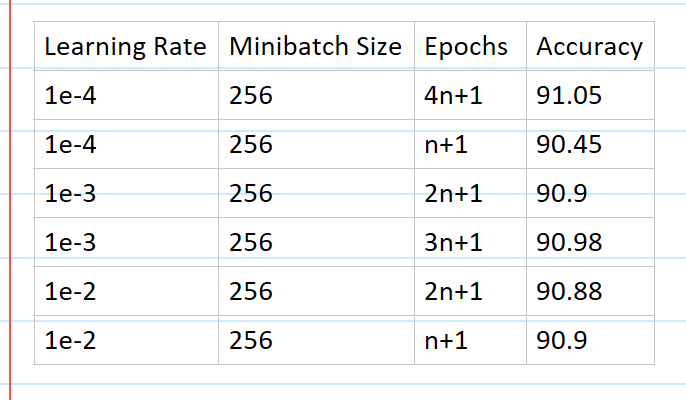

In [61]:
Image("../optimization_final/raw/minibatch_param_accuracies.png")

#### Adagrad
$G^{k} = G^{k−1} + ∇J(θ^{k−1})^2$<br>
$θ^{k} = θ^{k−1} – α / sqrt(G^{k−1}) * ∇J(θ^{k−1})$

In [28]:
from random import sample
import math
def adagrad(f_grad,
            x0,
            data,
            args,
            stepsize = 1e-2, 
            fudge_factor = 1e-6, 
            max_it=1000, 
            minibatchsize=None, 
            minibatch_ratio=0.01):
    # f_grad returns the loss functions gradient
    # x0 are the initial parameters (a starting point for the optimization)
    # data is a list of training data
    # args is a list or tuple of additional arguments passed to fgrad
    # stepsize is the global stepsize fir adagrad
    # fudge_factor is a small number to counter numerical instabiltiy
    # max_it is the number of iterations adagrad will run
    # minibatchsize if given is the number of training samples considered in each iteration
    # minibatch_ratio if minibatchsize is not set this ratio will be used to determine the batch size dependent on the length of the training data
    
    #d-dimensional vector representing diag(Gt) to store a running total of the squares of the gradients.
    gti = np.zeros(x0.shape[0])
    
    ld = len(data)
    if minibatchsize is None:
        minibatchsize = int(math.ceil(len(data)*minibatch_ratio))
    w = x0
    for t in range(max_it):
        s = sample(xrange(ld), minibatchsize)
        sd = [data[idx] for idx in s]
        grad = f_grad(w, sd, *args)
        gti += grad**2
        adjusted_grad = grad / (fudge_factor + np.sqrt(gti))
        w = w - stepsize*adjusted_grad
    return w


In [29]:
adagrad(f_grad=, x0=, data=, args=)

SyntaxError: invalid syntax (<ipython-input-29-277d8526cb12>, line 1)

In [ ]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .01
reg_lambda = .01

gti = X_train.shape[0]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

w = layer1_weights_array

for step in range(0,n+1):

    input_layer = np.dot(X_train, w)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    grad = regularization_L2_softmax_loss(reg_lambda, w, layer2_weights_array)
    loss += grad
    
    gti += grad**2
    adjusted_grad = grad / np.sqrt(gti)
    w = w - learning_rate*adjusted_grad

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * w

    w -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            print('Adagrad parameters are step {0}: {1}'.format(step, w))


# Testing stock versions

We'd like to compare our results to a stock version of SGD.

We'll create a keras nn with 5 hidden nodes as we've done in the hard coded example.

### Setting parameters to match hand coded full batch gradient descent

In the neural network terminology:

one epoch = one forward pass and one backward pass of all the training examples

batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.

number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

The below uses the full dataset as the batch size and n+1 as the number of epochs, matching the full batch gradient descent hand coded above. Time to convergence is TBD but upwards of 20 minutes.

In [4]:
# define baseline model
def nn_model():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [5]:
estimator = KerasClassifier(build_fn=nn_model,epochs = n, batch_size = len(X_train), verbose = 0)

NameError: name 'n' is not defined

In [ ]:
%time estimator.fit(X_train,y_train)

In [ ]:
print("Accuracy of NN on test: ", estimator.score(X_test,y_test))